<a href="https://colab.research.google.com/github/asupraja3/ml-ng-notebooks/blob/main/ClassificationEgs1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Optional Lab: Classification using Logistic Regression

*Adapted, self-contained version inspired by Andrew Ng's Machine Learning Specialization.*  
This notebook contrasts **regression** and **classification** and shows why **logistic regression** is a better choice for binary outcomes than using linear regression with an arbitrary threshold.

**You will:**  
1. Plot small 1D and 2D classification datasets.  
2. Try **Linear Regression + threshold** on categorical targets (and see its limitations).  
3. Train **Logistic Regression** and inspect probabilities and decision boundaries.  
4. Compare results visually and with simple metrics.

**Prereqs:** Basic NumPy, matplotlib, and scikit-learn.


In [ ]:

# === Setup ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Matplotlib: ensure plots render inline in Jupyter
# %matplotlib inline  # Uncomment if needed in your environment

np.set_printoptions(precision=3, suppress=True)



## Classification Problems (Binary)

**Examples:** spam vs not spam, fraudulent vs legitimate transaction, malignant vs benign tumor.  
Outcomes are **discrete** (0/1), not continuous numbers.

**Conventions:**  
- We will use `y = 1` for the **positive** class (e.g., malignant).  
- We will use `y = 0` for the **negative** class (e.g., benign).

> In small teaching datasets, we often visualize class labels with different markers.  
> In real projects, features can be high-dimensional and not easily plotted.


In [ ]:

# === Toy datasets (match the lecture's spirit) ===

# 1D dataset (tumor size -> malignant?)
x_train = np.array([0., 1., 2., 3., 4., 5.])
y_train = np.array([0, 0, 0, 1, 1, 1])

# 2D dataset (two features -> label). Each row is a sample [x0, x1].
x_train2 = np.array([
    [0.5, 1.5],
    [1.0, 1.0],
    [1.5, 0.5],
    [3.5, 0.5],
    [2.0, 2.0],
    [1.0, 2.5]
])
y_train2 = np.array([0, 0, 0, 1, 1, 1])

print("1D shapes:", x_train.shape, y_train.shape)
print("2D shapes:", x_train2.shape, y_train2.shape)


1D shapes: (6,) (6,)
2D shapes: (6, 2) (6,)



## Visualizing the data

Left: single feature vs class label.  
Right: two features, where position indicates the input and marker indicates the class.


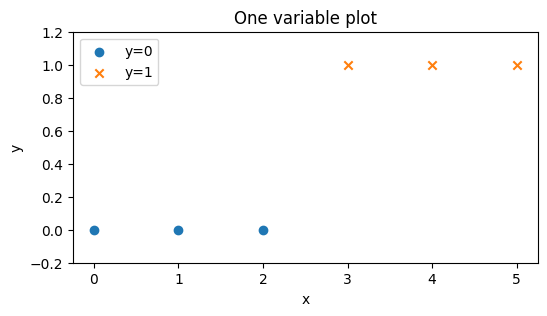

In [ ]:

# --- Plot: single variable (x vs class) ---
fig, ax = plt.subplots(figsize=(6, 3))
pos = y_train == 1
neg = y_train == 0
ax.scatter(x_train[neg], y_train[neg], marker='o', label='y=0')
ax.scatter(x_train[pos], y_train[pos], marker='x', label='y=1')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("One variable plot")
ax.set_ylim(-0.2, 1.2)
ax.legend()
plt.show()


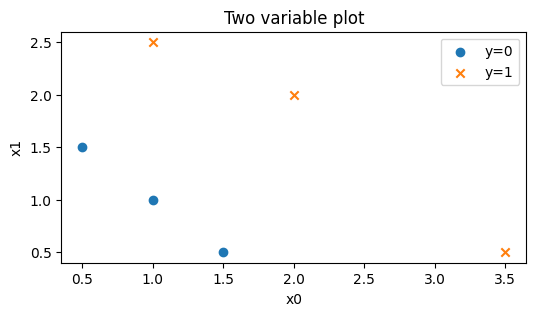

In [ ]:

# --- Plot: two variables (x0 vs x1) ---
fig, ax = plt.subplots(figsize=(6, 3))
pos2 = y_train2 == 1
neg2 = y_train2 == 0
ax.scatter(x_train2[neg2, 0], x_train2[neg2, 1], marker='o', label='y=0')
ax.scatter(x_train2[pos2, 0], x_train2[pos2, 1], marker='x', label='y=1')
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_title("Two variable plot")
ax.legend()
plt.show()



## Linear Regression Approach (and its problem)

You may try to treat `y ∈ {0,1}` as numbers and fit **linear regression**, then apply a **0.5 threshold**:
- Predict a *continuous* value `ŷ` and classify as 1 if `ŷ ≥ 0.5`, else 0.
- This can work **accidentally** on some datasets but fails to model probabilities in `[0,1]`.  
- Predictions can go below 0 or above 1, and extrapolation can be misleading.

Let's try it on the 1D dataset.


Linear Regression coefficients: [0.257] intercept: -0.1428571428571428
Raw predictions (continuous): [-0.143  0.114  0.371  0.629  0.886  1.143]
Thresholded predictions: [0 0 0 1 1 1]
Accuracy: 1.0
[[3 0]
 [0 3]]


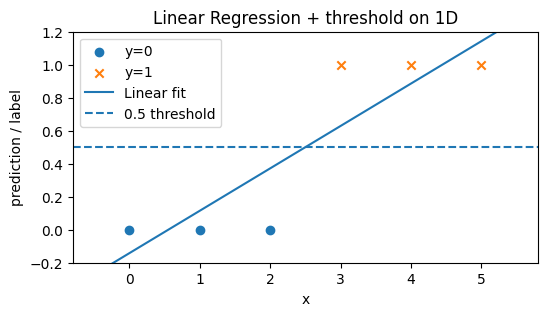

In [ ]:

# === Linear Regression + threshold on 1D ===
X1 = x_train.reshape(-1, 1)
linreg = LinearRegression().fit(X1, y_train)
yhat_lr = linreg.predict(X1)

print("Linear Regression coefficients:", linreg.coef_, "intercept:", linreg.intercept_)
print("Raw predictions (continuous):", yhat_lr)

# Apply 0.5 threshold to map to {0,1}
yhat_cls = (yhat_lr >= 0.5).astype(int)
print("Thresholded predictions:", yhat_cls)
print("Accuracy:", accuracy_score(y_train, yhat_cls))
print(confusion_matrix(y_train, yhat_cls))

# Plot the fitted line and threshold
xs = np.linspace(x_train.min()-0.5, x_train.max()+0.5, 200).reshape(-1, 1)
ys = linreg.predict(xs)

fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(x_train[y_train==0], y_train[y_train==0], marker='o', label='y=0')
ax.scatter(x_train[y_train==1], y_train[y_train==1], marker='x', label='y=1')
ax.plot(xs, ys, label='Linear fit')
ax.axhline(0.5, linestyle='--', label='0.5 threshold')
ax.set_xlabel("x")
ax.set_ylabel("prediction / label")
ax.set_title("Linear Regression + threshold on 1D")
ax.set_ylim(-0.2, 1.2)
ax.legend()
plt.show()


## Logistic Regression

**Idea:**  
We want to model the probability of the positive class:  

$$
P(y = 1 \mid x) = \sigma(w^T x + b)
$$

where the sigmoid function is defined as:  

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

---

**Properties:**  
- Outputs are probabilities in the range \([0,1]\).  
- The **decision rule** is:  

$$
\hat{y} =
\begin{cases}
1 & \text{if } P(y=1 \mid x) \geq 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

---

**Next Step:**  
Let's fit logistic regression on the same 1D dataset and compare results with linear regression.


Logistic Regression probabilities: [0.057 0.157 0.363 0.636 0.843 0.943]
Logistic Regression predictions: [0 0 0 1 1 1]
Logistic Coef: [[1.121]] Intercept: [-2.802]
Train accuracy: 1.0
[[3 0]
 [0 3]]


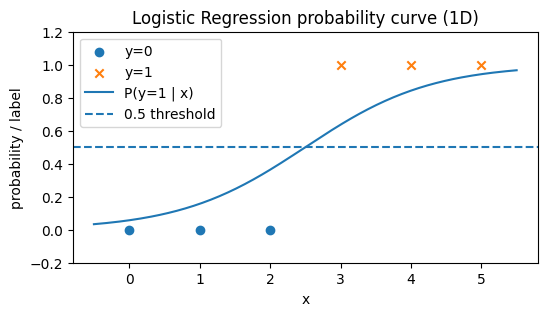

In [ ]:

# === Logistic Regression on 1D ===
# ------------------------------------------------------
# 1. Create the Logistic Regression model
# ------------------------------------------------------
# solver='lbfgs':
#   - 'lbfgs' is a quasi-Newton optimization algorithm.
#   - Suitable for small/medium datasets.
#   - Works well with L2 regularization (default).
#   - Finds model parameters (weights + bias) that minimize log loss.
logreg_1d = LogisticRegression(solver='lbfgs')

# ------------------------------------------------------
# 2. Fit (train) the model
# ------------------------------------------------------
# This step:
#   - Computes optimal weights (w) and bias (b)
#   - Uses training data X1 and labels y_train
#   - Minimizes the cross-entropy (log loss) cost function
logreg_1d.fit(X1, y_train)

# ------------------------------------------------------
# 3. Get predicted probabilities for class 1
# ------------------------------------------------------
# predict_proba(X):
#   - Returns probability estimates for each class
#   - Output shape: (m, 2)
#       Column 0 → P(y=0 | x)
#       Column 1 → P(y=1 | x)
#   - For binary classification, P(y=1) = sigmoid(w·x + b)
proba_1d = logreg_1d.predict_proba(X1)[:, 1]
print("Logistic Regression probabilities:", proba_1d)
# '[:, 1]' selects only column 1 (probability of class 1)

# ------------------------------------------------------
# 4. Convert probabilities into binary predictions
# ------------------------------------------------------
# Thresholding:
#   - If probability >= 0.5 → predict class 1
#   - Else → predict class 0
# (proba_1d >= 0.5) returns boolean array: True/False
# astype(int) converts:
#   True  → 1
#   False → 0
yhat_log_1d = (proba_1d >= 0.5).astype(int)
print("Logistic Regression predictions:", yhat_log_1d)


print("Logistic Coef:", logreg_1d.coef_, "Intercept:", logreg_1d.intercept_)
print("Train accuracy:", accuracy_score(y_train, yhat_log_1d))
print(confusion_matrix(y_train, yhat_log_1d))

# Plot probability curve
xs = np.linspace(x_train.min()-0.5, x_train.max()+0.5, 200).reshape(-1, 1)
probs = logreg_1d.predict_proba(xs)[:, 1]

fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(x_train[y_train==0], y_train[y_train==0], marker='o', label='y=0')
ax.scatter(x_train[y_train==1], y_train[y_train==1], marker='x', label='y=1')
ax.plot(xs, probs, label='P(y=1 | x)')
ax.axhline(0.5, linestyle='--', label='0.5 threshold')
ax.set_xlabel("x")
ax.set_ylabel("probability / label")
ax.set_title("Logistic Regression probability curve (1D)")
ax.set_ylim(-0.2, 1.2)
ax.legend()
plt.show()



## 2D case and Decision Boundary

We'll fit both models on the 2D dataset and visualize the **decision boundary**:
- For **linear regression + threshold**, use the fitted plane and cut at 0.5.
- For **logistic regression**, plot where $$\sigma(w^T x + b) = 0.5$$which is the line $$w^T x + b = 0$$


2D Linear Regression w: [0.505 0.59 ] b: -1.0861601085481682
2D Logistic Regression w: [0.904 0.781] b: -2.464768556204597


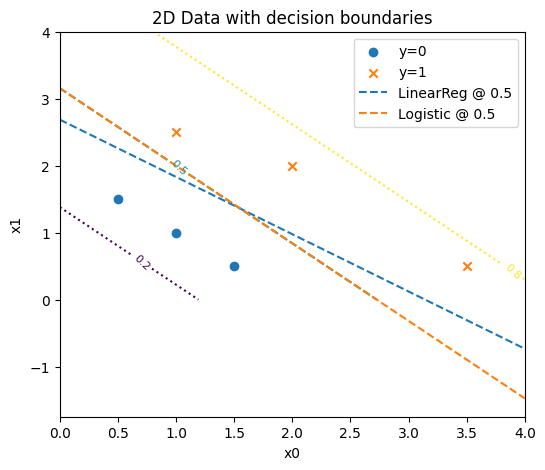

In [ ]:

# Helper to draw a linear boundary given coefficients and intercept at a desired level (0.5 by default)
def plot_linear_boundary(ax, w, b, level=0.5, xlim=(0, 4), ylim=(0, 4), label="boundary"):
    # For a plane yhat = w0*x0 + w1*x1 + b, boundary for yhat=level is w0*x0 + w1*x1 + b = level
    # Solve for x1 = -(w0*x0 + b - level)/w1  (if w1 != 0)
    x0s = np.linspace(xlim[0], xlim[1], 100)
    if abs(w[1]) < 1e-8:
        return  # vertical-ish boundary; skip for simplicity
    x1s = -(w[0]*x0s + b - level) / w[1]
    ax.plot(x0s, x1s, linestyle='--', label=label)

# Fit Linear Regression on 2D and derive thresholded classifier
lin2 = LinearRegression().fit(x_train2, y_train2)
print("2D Linear Regression w:", lin2.coef_, "b:", lin2.intercept_)

# Fit Logistic Regression on 2D
log2 = LogisticRegression(solver='lbfgs')
log2.fit(x_train2, y_train2)
print("2D Logistic Regression w:", log2.coef_[0], "b:", log2.intercept_[0])

# Grid for background probabilities (logistic) to see the surface qualitatively
x0_range = np.linspace(0, 4, 200)
x1_range = np.linspace(0, 4, 200)
xx0, xx1 = np.meshgrid(x0_range, x1_range)
grid = np.c_[xx0.ravel(), xx1.ravel()]
probs2 = log2.predict_proba(grid)[:, 1].reshape(xx0.shape)

# Scatter + boundaries
fig, ax = plt.subplots(figsize=(6, 5))
pos2 = y_train2 == 1
neg2 = y_train2 == 0
ax.scatter(x_train2[neg2, 0], x_train2[neg2, 1], marker='o', label='y=0')
ax.scatter(x_train2[pos2, 0], x_train2[pos2, 1], marker='x', label='y=1')
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_title("2D Data with decision boundaries")

# optional: draw a few probability contours for logistic (0.2, 0.5, 0.8)
cs = ax.contour(xx0, xx1, probs2, levels=[0.2, 0.5, 0.8], linestyles=[':', '--', ':'])
ax.clabel(cs, fmt={0.2: '0.2', 0.5: '0.5', 0.8: '0.8'}, inline=True, fontsize=8)

# Linear Regression + threshold boundary at yhat=0.5
plot_linear_boundary(ax, lin2.coef_, lin2.intercept_, level=0.5, label="LinearReg @ 0.5")

# Logistic boundary at prob=0.5 => w^T x + b = 0
w = log2.coef_[0]
b = log2.intercept_[0]
# For sigmoid(w·x+b)=0.5 => w·x + b = 0  -> x1 = -(w0*x0 + b)/w1
plot_linear_boundary(ax, w, b, level=0.0, label="Logistic @ 0.5")

ax.legend()
plt.show()



## Quantitative comparison

We'll compare accuracy on the training set (for small toy data this is fine).  
In practice, use a train/validation split or cross-validation.


In [ ]:

# Compare predictions on 2D
yhat_lr2 = (lin2.predict(x_train2) >= 0.5).astype(int)
yhat_log2 = log2.predict(x_train2)

print("Linear Regression + threshold (2D)")
print("  Acc:", accuracy_score(y_train2, yhat_lr2))
print(confusion_matrix(y_train2, yhat_lr2))
print(classification_report(y_train2, yhat_lr2, digits=3))

print("\nLogistic Regression (2D)")
print("  Acc:", accuracy_score(y_train2, yhat_log2))
print(confusion_matrix(y_train2, yhat_log2))
print(classification_report(y_train2, yhat_log2, digits=3))


Linear Regression + threshold (2D)
  Acc: 1.0
[[3 0]
 [0 3]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6


Logistic Regression (2D)
  Acc: 1.0
[[3 0]
 [0 3]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6




## Takeaways

- **Linear Regression + threshold** is not probabilistic and can extrapolate outside $$[0,1]$$.  
- **Logistic Regression** directly models $$P(y=1\mid x)$$with outputs in $$[0,1]$$.  
- The **decision boundary** in logistic regression for threshold 0.5 is the set $$w^T x + b = 0$$.  
- For linearly separable data, a linear boundary can work well; for more complex patterns, consider **feature engineering** or **non-linear models** (e.g., kernels, trees, neural networks).

**Suggested exercises:**
1. Try shifting a few points and re-run to see how boundaries change.  
2. Add polynomial features to the 2D data and fit logistic regression again.  
3. Replace logistic regression with other classifiers (SVM, RandomForest) and compare.
